MSE = 0.028834565000847186


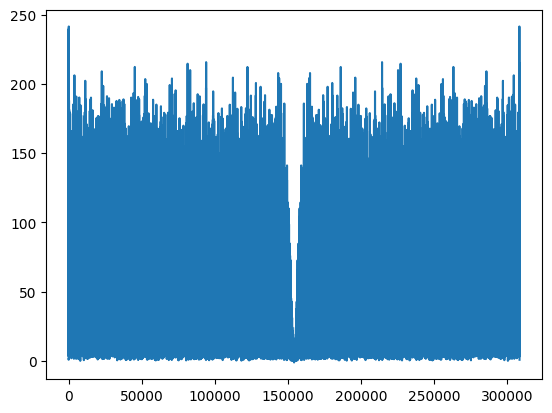

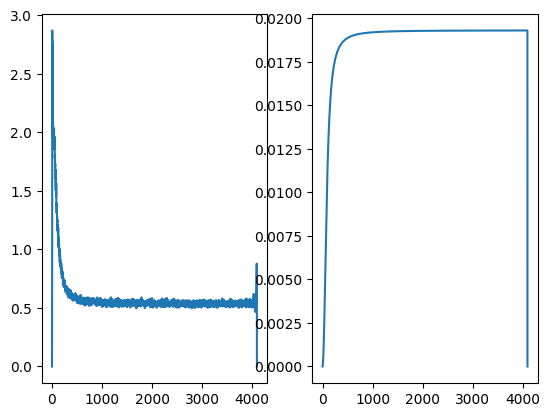

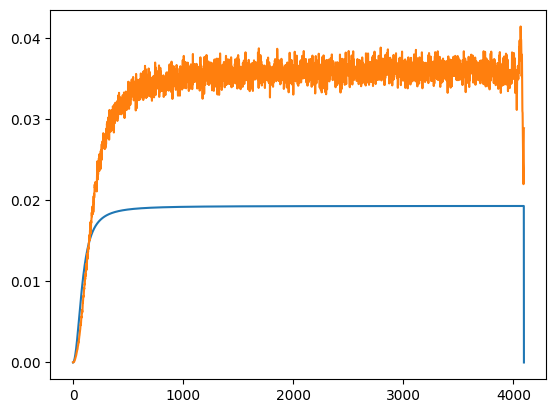

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import stft, istft, butter, filtfilt
from IPython.display import Audio
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d

def filtering(Zxx, filter, fs, nperseg, noverlap):
    Z = Zxx.copy()
    for i in range(Zxx.shape[1]):
        Z[:, i] *= filter
    
    _, filtered_signal = istft(Z, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return filtered_signal.real

def cal_FRF(Xi, Yi):
    return np.mean((np.conj(Xi) * Yi), axis=1) / np.mean(np.conj(Xi) * Xi, axis=1)

# load input & output noise
input_noise,  fs = sf.read('input_white_noise.wav')
output_noise, fs = sf.read('output_white_noise.wav')
output_noise = output_noise[:input_noise.shape[0]]

# short time Fourier transform
nperseg = 8192
noverlap = nperseg * 0.75
f_input, t_input, Xi = stft(input_noise, fs=fs, nperseg=nperseg, noverlap=noverlap)
f_output, t_output, Yi = stft(output_noise, fs=fs, nperseg=nperseg, noverlap=noverlap)

# H(f): FRF of the loudspeaker
H = np.mean((np.conj(Xi) * Yi), axis=1) / np.mean(np.conj(Xi) * Xi, axis=1)
smooth = True
# if smooth:
#     # H = gaussian_filter1d(np.abs(H), sigma=20) * np.exp(1j * np.angle(H))
#     b, a = butter(6, 900 / (fs/2), 'low')
#     H = filtfilt(b, a, H)

# design W(f)
M = np.load("desired FRF.npy")  # M(f): desired FRF 
episilon = 1e-6 * np.max(np.abs(H))
W = M / (H + episilon)              # compensate filter W(f) = M(f) / H(f)
# smooth = True
# if smooth:
#     W = gaussian_filter1d(np.abs(W), sigma=20) * np.exp(1j * np.angle(W))


# compensate the output_noise
enhanced_noise = filtering(Yi, W, fs, nperseg, noverlap)    
enhanced_noise *= 10
sf.write('PEAQ\enhanced_noise.wav', enhanced_noise, fs)

# filtering input_noise by M(f) as a reference
ideal_noise = filtering(Xi, M, fs, nperseg, noverlap)       
sf.write('PEAQ\ideal_noise.wav', ideal_noise, fs)


# load compensated noise
enhanced_noise, fs = sf.read('PEAQ\enhanced_noise.wav')          
enhanced_noise = enhanced_noise[:input_noise.shape[0]] 

# calculate FRF and MSE
_, _, Wi = stft(enhanced_noise, fs=fs, nperseg=nperseg, noverlap=noverlap)
FRF = np.mean((np.conj(Xi) * Wi), axis=1) / np.mean(np.conj(Xi) * Xi, axis=1)
print('MSE =', mean_squared_error(np.abs(FRF), np.abs(M)))

# load compensated noise
ideal_noise, fs = sf.read('PEAQ\ideal_noise.wav')          
ideal_noise = ideal_noise[:input_noise.shape[0]]

plt.figure()
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(enhanced_noise))) - \
         np.abs(np.fft.fftshift(np.fft.fft(output_noise))))
plt.show()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(np.abs(W))
plt.subplot(1, 2, 2)
plt.plot(np.abs(W*H))
plt.figure()
plt.plot(np.abs(M))
plt.plot(np.abs(H))
plt.show()

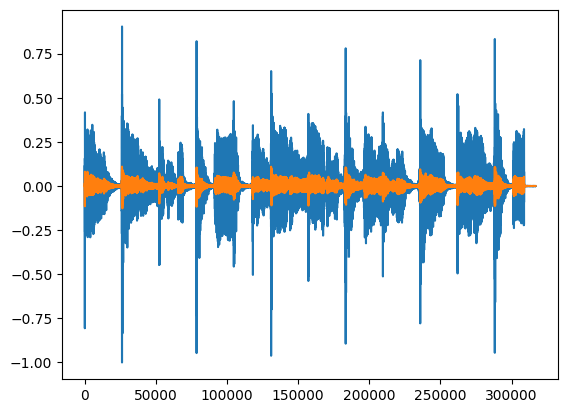

In [87]:
# compensate output_music.wav
output_music, fs_output = sf.read('output_music.wav')
f_output, t_output, X_output = stft(output_music, fs=fs_output, nperseg=nperseg, noverlap=nperseg*0.75)

enhanced_music = filtering(X_output, W, fs_output, nperseg, nperseg*0.75)
enhanced_music *= 8
# b, a = butter(6, 80 / (fs/2), 'high')
# enhanced_music = filtfilt(b, a, enhanced_music)

# b, a = butter(6, 0.5, 'low')
# enhanced_music = filtfilt(b, a, output_music)
sf.write('PEAQ\output_music_compensated_113061530.wav', enhanced_music, fs_output)

enhanced_music, fs = sf.read('PEAQ\output_music_compensated_113061530.wav')
enhanced_music = enhanced_music[:output_music.shape[0]]

ref_music, _ = sf.read('answer.wav')
ref_music = ref_music[:output_music.shape[0]]

plt.figure()
plt.plot(ref_music)
plt.plot(enhanced_music)
plt.show()

# plt.figure()
# plt.plot(np.abs(np.fft.fftshift(np.fft.fft(output_music))))
# plt.plot(np.abs(np.fft.fftshift(np.fft.fft(enhanced_music))))
# plt.title('Spectrum')
# plt.legend(['output_music', 'compensated'])
# plt.show()

Audio('PEAQ\output_music_compensated_113061530.wav')

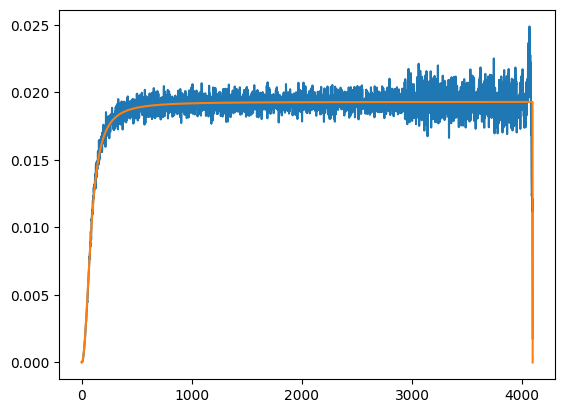

In [11]:
output_music, fs_output = sf.read('output_music.wav')
f_output, t_output, X_output = stft(output_music, fs=fs_output, nperseg=nperseg, noverlap=nperseg*0.75)

enhanced_music, fs_output = sf.read('output_music_compensated_113061530.wav')
f_output, t_output, X_enhanced = stft(enhanced_music, fs=fs_output, nperseg=nperseg, noverlap=nperseg*0.75)

FRF = cal_FRF(Xi=X_output, Yi=X_enhanced)
plt.figure()
plt.plot(np.abs(FRF*H))
plt.plot(np.abs(M))
plt.show()